In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, GaussianNoise
from tensorflow.keras import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
aminos = {'K': 0, 'V': 1, 'W': 2, 'Q': 3, 'H': 4, 'G': 5, 'P': 6, 'M': 7, 'S': 8, 'F': 9, 'A': 10, 'T': 11, 'R': 12, 'E': 13, 'N': 14, 'L': 15, 'C': 16, 'I': 17, 'Y': 18, 'D': 19}


In [ ]:
with open('/content/neg_A0201.txt') as f:
    neg = np.array([x.upper() for x in f.read().splitlines()])

with open('/content/pos_A0201.txt') as f:
    pos = np.array([x.upper() for x in f.read().splitlines()])

neg_labels = np.zeros(neg.shape,dtype=np.uint8)
pos_labels = np.ones(pos.shape,dtype=np.uint8)

idx_train_neg = np.random.choice(neg_labels.shape[0],size=int(0.9*neg_labels.shape[0]),replace=False)
neg_train_labels = neg_labels[idx_train_neg]
neg_train_data = neg[idx_train_neg]

idx_test_neg = ~np.isin(np.arange(neg_labels.shape[0]),idx_train_neg)
neg_test_labels= neg_labels[idx_test_neg]
neg_test_data = neg[idx_test_neg]


idx_train_pos = np.random.choice(pos_labels.shape[0],size=int(0.9*pos_labels.shape[0]),replace=False)
pos_train_labels = pos_labels[idx_train_pos]
pos_train_data = pos[idx_train_pos]

idx_test_pos = ~np.isin(np.arange(pos_labels.shape[0]),idx_train_pos)
pos_test_labels= pos_labels[idx_test_pos]
pos_test_data = pos[idx_test_pos]

train_labels = np.concatenate([pos_train_labels, neg_train_labels])
test_labels = np.concatenate([pos_test_labels, neg_test_labels])
train_data = np.concatenate([pos_train_data, neg_train_data])
test_data = np.concatenate([pos_test_data, neg_test_data])



idx_perm_test = np.arange(test_labels.shape[0])
idx_perm_train = np.arange(train_labels.shape[0])

np.random.shuffle(idx_perm_test)
np.random.shuffle(idx_perm_train)

x_train_data = train_data[idx_perm_train][:, None]
x_test_data = test_data[idx_perm_test][:, None]
y_train = train_labels[idx_perm_train]
y_test = test_labels[idx_perm_test]



# New Section

In [ ]:
def amino2vec(s):
    s = s[0]
    vec = np.zeros((20, 9))
    for i, c in enumerate(s):
        vec[aminos[c], i] = 1
    return vec.flatten()

x_train = np.zeros((x_train_data.shape[0], 20 * 9))
x_train = np.apply_along_axis(amino2vec, 1, x_train_data)

x_test = np.zeros((x_test_data.shape[0], 20 * 9))
x_test = np.apply_along_axis(amino2vec, 1, x_test_data)


In [ ]:

# def amino2vec(s):
#     s = s[0]
#     aminos = {'K': 0, 'V': 1, 'W': 2, 'Q': 3, 'H': 4, 'G': 5, 'P': 6, 'M': 7, 'S': 8, 'F': 9, 'A': 10, 'T': 11, 'R': 12, 'E': 13, 'N': 14, 'L': 15, 'C': 16, 'I': 17, 'Y': 18, 'D': 19}
#     v = np.zeros(9)
#     for i, c in enumerate(s):
#         v[i] = aminos[c]
#     return v

# x = np.zeros((data.shape[0], 9))
# x = np.apply_along_axis(amino2vec, 1, data)
# print(x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 6.460933208465576, Accuracy: 90.5672607421875, Test Loss: 6.255784034729004, Test Accuracy: 91.81818389892578
Epoch 2, Loss: 6.144575595855713, Accuracy: 92.50394439697266, Test Loss: 6.163145065307617, Test Accuracy: 92.36363983154297
Epoch 3, Loss: 6.069397926330566, Accuracy: 93.0538101196289, Test Loss: 6.161314010620117, Test Accuracy: 92.29090881347656
Epoch 4, Loss: 6.012241840362549, Accuracy: 93.51069641113281, Test Loss: 6.137423515319824, Test Accuracy: 92.43636322021484
Epoch 

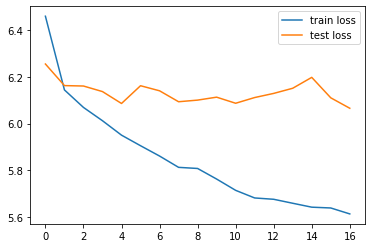

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(16)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(16)

class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d0 = Dense(512)
    self.l0 = LeakyReLU()
    self.d1 = Dense(128)
    self.l1 = LeakyReLU()
    self.d6 = Dense(2, activation='softmax')

  def call(self, x):
    x = self.d0(x)
    x = self.l0(x)
    x = self.d1(x)
    x = self.l1(x)
    return self.d6(x)


# Create an instance of the model
model = MyModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.SUM)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(vectors, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(vectors, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(vectors, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(vectors, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

EPOCHS = 17

loss = np.zeros((2, EPOCHS))
for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

  loss[0, epoch] = train_loss.result()
  loss[1, epoch] = test_loss.result()

plt.plot(loss[0], label='train loss')
plt.plot(loss[1], label='test loss')
plt.legend()
plt.show()


In [ ]:
from itertools import groupby

def fastaread(fasta_name):
    f = open(fasta_name)
    faiter = (x[1] for x in groupby(f, lambda line: line.startswith(">")))
    for header in faiter:
        header = next(header)[1:].strip()
        seq = "".join(s.strip() for s in next(faiter))
        yield header, seq

sequence = [line for line in fastaread('/content/P0DTC2.fasta')][0][1]
print(len(sequence))
sequences = np.array([sequence[i: i + 9] for i in range(len(sequence) - 9)])[:, None]
vecs = np.apply_along_axis(amino2vec, 1, sequences)
seq_prediction = model(vecs, training=False)
print(np.count_nonzero(seq_prediction == 1))
print(np.count_nonzero(seq_prediction == 1)/len(sequence))

1273
1210
0.950510604870385
